# 구별로 모델 별도 생성

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import gc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import joblib

# 맥에서 글씨 깨짐 방지
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# Data Load

In [2]:
df = pd.read_csv('../data/22_subway_line.csv')

/tmp/ipykernel_588247/1581810781.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/22_subway_line.csv')


In [3]:
df.shape

(1128094, 95)

In [4]:
# 일부 feature 제거 - 기준은 내마음대로

df.drop(['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
         'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
         'k-사용검사일-사용승인일', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)', 'k-전용면적별세대현황(60~85이하)',
         'k-85~135이하', 'k-135초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태',
         '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'], axis=1, inplace=True)

In [6]:
# 추가로 제거가 필요한 feature 제거
df.drop(['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-관리방식', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적',
         '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '시군구 번지', '좌표X,좌표Y', 'index', '역사_ID', '역사명', '위도', '경도',
         '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호', '가장 가까운 버스 정류소명',
         '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표', '가장 가까운 버스 정류장 Y좌표', '동', 
         '호선'], axis=1, inplace=True)

In [7]:
df.columns

Index(['전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test',
       '가장 가까운 거리', '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년',
       '계약월', 'GDP', '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량',
       '건설사 랭킹', '구', '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하',
       '구매력지수', '거래활발지수', '매매가격 지수 증감률', '매매 대비 전세가격 비율', '아파트 카테고리',
       '지하철 카테고리'],
      dtype='object')

In [8]:
print(df.shape)
df.head(10)

(1128094, 35)


,전용면적,계약년월,계약일,층,건축년도,좌표X,좌표Y,target,is_test,가장 가까운 거리,...,공시지가 평균,매수우위지수,건물나이,30년이상50년이하,구매력지수,거래활발지수,매매가격 지수 증감률,매매 대비 전세가격 비율,아파트 카테고리,지하철 카테고리
0,79.97,201712,8,3,1987,127.05721,37.476763,124000.0,0,1127.738351,...,6.858562e+06,88.4,30,1,48.262095,17.693929,1.243615,70.0590,기타,분당선
1,79.97,201712,22,4,1987,127.05721,37.476763,123500.0,0,1127.738351,...,6.858562e+06,88.4,30,1,48.262095,17.693929,1.243615,70.0590,기타,분당선
2,54.98,201712,28,5,1987,127.05721,37.476763,91500.0,0,1127.738351,...,6.858562e+06,88.4,30,1,48.262095,17.693929,1.243615,70.0590,기타,분당선
3,79.97,201801,3,4,1987,127.05721,37.476763,130000.0,0,1127.738351,...,7.322618e+06,118.0,31,1,46.647899,27.764117,2.459291,69.3220,기타,분당선
4,79.97,201801,8,2,1987,127.05721,37.476763,117000.0,0,1127.738351,...,7.322618e+06,118.0,31,1,46.647899,27.764117,2.459291,69.3220,기타,분당선
5,79.97,201801,11,1,1987,127.05721,37.476763,130000.0,0,1127.738351,...,7.322618e+06,118.0,31,1,46.647899,27.764117,2.459291,69.3220,기타,분당선
6,79.97,201803,19,2,1987,127.05721,37.476763,139500.0,0,1127.738351,...,7.322618e+06,103.9,31,1,44.831392,25.426767,2.180755,67.1875,기타,분당선
7,54.98,201804,5,5,1987,127.05721,37.476763,107500.0,0,1127.738351,...,7.322618e+06,79.0,31,1,43.176009,10.606186,1.280568,66.2450,기타,분당선
8,79.97,201806,28,3,1987,127.05721,37.476763,145000.0,0,1127.738351,...,7.322618e+06,77.8,31,1,42.659752,9.905748,0.274474,65.3984,기타,분당선
9,54.98,201807,9,3,1987,127.05721,37.476763,112000.0,0,1127.738351,...,7.322618e+06,84.1,31,1,44.750023,13.242790,0.218161,64.8121,기타,분당선


In [9]:
# 계약월 변수 생성
df['계약월'] = df['계약년월'].astype(str).str[4:].astype(int)

# 계약년월, 계약일, 건축년도, 계약년 변수 제거
df.drop(['계약년월', '계약일'], axis=1, inplace=True)

df['계약월_sin'] = np.sin(2 * np.pi * df['계약월'] / 12)
df.drop(['계약월'], axis=1, inplace=True)

In [10]:
df.head()

,전용면적,층,건축년도,좌표X,좌표Y,target,is_test,가장 가까운 거리,인근 지하철 역 개수,가장 가까운 버스 정류장 거리,...,매수우위지수,건물나이,30년이상50년이하,구매력지수,거래활발지수,매매가격 지수 증감률,매매 대비 전세가격 비율,아파트 카테고리,지하철 카테고리,계약월_sin
0,79.97,3,1987,127.05721,37.476763,124000.0,0,1127.738351,2.0,61.89584,...,88.4,30,1,48.262095,17.693929,1.243615,70.059,기타,분당선,-2.449294e-16
1,79.97,4,1987,127.05721,37.476763,123500.0,0,1127.738351,2.0,61.89584,...,88.4,30,1,48.262095,17.693929,1.243615,70.059,기타,분당선,-2.449294e-16
2,54.98,5,1987,127.05721,37.476763,91500.0,0,1127.738351,2.0,61.89584,...,88.4,30,1,48.262095,17.693929,1.243615,70.059,기타,분당선,-2.449294e-16
3,79.97,4,1987,127.05721,37.476763,130000.0,0,1127.738351,2.0,61.89584,...,118.0,31,1,46.647899,27.764117,2.459291,69.322,기타,분당선,5.000000e-01
4,79.97,2,1987,127.05721,37.476763,117000.0,0,1127.738351,2.0,61.89584,...,118.0,31,1,46.647899,27.764117,2.459291,69.322,기타,분당선,5.000000e-01


In [11]:
df.columns

Index(['전용면적', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', 'GDP',
       '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹', '구',
       '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율', '아파트 카테고리', '지하철 카테고리', '계약월_sin'],
      dtype='object')

# scaling

In [13]:
def scailing(col, scaler_type):
    if scaler_type == 'min_max': scaler = MinMaxScaler()
    else : scaler = StandardScaler()

    return scaler.fit_transform(df[[col]])

cols = ['전용면적', '층', '건축년도', '좌표X', '좌표Y', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', 'GDP',
       '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량',
       '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율', '계약월_sin']

for col in cols:
    print(col)
    scaler_type = 'min_max'
    if col == '계약월_sin': scaler_type = 'standard'

    df[[col]] = scailing(col, scaler_type)

전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
계약월_sin


In [14]:
df

,전용면적,층,건축년도,좌표X,좌표Y,target,is_test,가장 가까운 거리,인근 지하철 역 개수,가장 가까운 버스 정류장 거리,...,매수우위지수,건물나이,30년이상50년이하,구매력지수,거래활발지수,매매가격 지수 증감률,매매 대비 전세가격 비율,아파트 카테고리,지하철 카테고리,계약월_sin
0,0.168839,0.095890,0.419355,0.678243,0.167126,124000.0,0,0.353721,0.086957,0.101599,...,0.513427,0.561644,1,0.388295,0.269203,0.526489,0.864178,기타,분당선,-0.022272
1,0.168839,0.109589,0.419355,0.678243,0.167126,123500.0,0,0.353721,0.086957,0.101599,...,0.513427,0.561644,1,0.388295,0.269203,0.526489,0.864178,기타,분당선,-0.022272
2,0.108520,0.123288,0.419355,0.678243,0.167126,91500.0,0,0.353721,0.086957,0.101599,...,0.513427,0.561644,1,0.388295,0.269203,0.526489,0.864178,기타,분당선,-0.022272
3,0.168839,0.109589,0.419355,0.678243,0.167126,130000.0,0,0.353721,0.086957,0.101599,...,0.702685,0.575342,1,0.342458,0.426615,0.639847,0.844200,기타,분당선,0.684200
4,0.168839,0.082192,0.419355,0.678243,0.167126,117000.0,0,0.353721,0.086957,0.101599,...,0.702685,0.575342,1,0.342458,0.426615,0.639847,0.844200,기타,분당선,0.684200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,0.180135,0.232877,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,0.191176,0.273973,0,0.301707,0.187420,0.350729,0.345867,기타,기타,-0.728745
1128090,0.180063,0.219178,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,0.191176,0.273973,0,0.301707,0.187420,0.350729,0.345867,기타,기타,-0.728745
1128091,0.221168,0.219178,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,0.242327,0.273973,0,0.297272,0.206827,0.353863,0.347283,기타,기타,-1.245919
1128092,0.180835,0.301370,0.854839,0.807949,0.728162,NaN,1,0.227756,0.173913,0.097533,...,0.212916,0.273973,0,0.288411,0.262852,0.389469,0.349765,기타,기타,-1.435218


# 호선 One-Hot encoding

In [14]:
ohe = OneHotEncoder(sparse=False)
ohe_re = ohe.fit_transform(df[['호선']])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
df = pd.concat([df, pd.DataFrame(ohe_re, columns=[col for col in ohe.categories_[0]])], axis=1)
df

,전용면적,층,건축년도,좌표X,좌표Y,target,is_test,가장 가까운 거리,호선,인근 지하철 역 개수,...,경춘선,공항철도1호선,과천선,분당선,신림선,신분당선,신분당선(연장2),우이신설선,일산선,중앙선
0,0.168839,0.095890,0.419355,0.678243,0.167126,124000.0,0,0.353721,분당선,0.086957,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.168839,0.109589,0.419355,0.678243,0.167126,123500.0,0,0.353721,분당선,0.086957,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.108520,0.123288,0.419355,0.678243,0.167126,91500.0,0,0.353721,분당선,0.086957,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.168839,0.109589,0.419355,0.678243,0.167126,130000.0,0,0.353721,분당선,0.086957,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.168839,0.082192,0.419355,0.678243,0.167126,117000.0,0,0.353721,분당선,0.086957,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,0.180135,0.232877,0.854839,0.807949,0.728162,NaN,1,0.227756,경춘선,0.173913,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128090,0.180063,0.219178,0.854839,0.807949,0.728162,NaN,1,0.227756,경춘선,0.173913,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128091,0.221168,0.219178,0.854839,0.807949,0.728162,NaN,1,0.227756,경춘선,0.173913,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128092,0.180835,0.301370,0.854839,0.807949,0.728162,NaN,1,0.227756,경춘선,0.173913,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df.drop(['호선'], axis=1, inplace=True)

## category

In [15]:
#df['30년이상50년이하'] = df['30년이상50년이하'].astype('category')
df['아파트 카테고리'] = df['아파트 카테고리'].astype('category')
df['지하철 카테고리'] = df['지하철 카테고리'].astype('category')
#df['구 카테고리'] = df['구 카테고리'].astype('category')
#df['건설사 카테고리'] = df['건설사 카테고리'].astype('category')
#df['인근 다리 개수 1개이상 3개 이하'] = df['인근 다리 개수 1개이상 3개 이하'].astype('category')
#df['학군'] = df['학군'].astype('category')

# Dataset 생성

In [16]:
train_df = df[df['is_test'] == 0]
test_df = df[df['is_test'] == 1]

In [17]:
print(train_df.shape)
print(test_df.shape)

(1118822, 33)
(9272, 33)


In [18]:
train_df.drop(['is_test'], axis=1, inplace=True)
test_df.drop(['is_test'], axis=1, inplace=True)

/tmp/ipykernel_588247/1571330888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['is_test'], axis=1, inplace=True)
/tmp/ipykernel_588247/1571330888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['is_test'], axis=1, inplace=True)


In [19]:
print(train_df.shape)
print(test_df.shape)

(1118822, 32)
(9272, 32)


## 구별로 분할

In [20]:
district_list = df['구'].unique().tolist()
print(len(district_list))
district_list

25


['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구']

In [21]:
df_list = []

for district in district_list:
    df_list.append(df[df['구'] == district])

In [22]:
df_list[1]

,전용면적,층,건축년도,좌표X,좌표Y,target,is_test,가장 가까운 거리,인근 지하철 역 개수,가장 가까운 버스 정류장 거리,...,매수우위지수,건물나이,30년이상50년이하,구매력지수,거래활발지수,매매가격 지수 증감률,매매 대비 전세가격 비율,아파트 카테고리,지하철 카테고리,계약월_sin
4452,0.179846,0.205479,0.774194,0.999922,0.492620,59500.0,0,0.123986,0.217391,0.074798,...,0.493606,0.260274,0,0.453113,0.248628,0.469404,0.886409,파크,5호선,-1.245919
4453,0.180352,0.123288,0.774194,0.999922,0.492620,59500.0,0,0.123986,0.217391,0.074798,...,0.491049,0.260274,0,0.416342,0.249653,0.487174,0.879703,파크,5호선,-0.728745
4454,0.180352,0.191781,0.774194,0.999922,0.492620,60000.0,0,0.123986,0.217391,0.074798,...,0.513427,0.260274,0,0.388295,0.269203,0.469610,0.864178,파크,5호선,-0.022272
4455,0.180570,0.068493,0.774194,0.999922,0.492620,53800.0,0,0.123986,0.217391,0.074798,...,0.513427,0.260274,0,0.388295,0.269203,0.469610,0.864178,파크,5호선,-0.022272
4456,0.180352,0.109589,0.774194,0.999922,0.492620,58000.0,0,0.123986,0.217391,0.074798,...,0.513427,0.260274,0,0.388295,0.269203,0.469610,0.864178,파크,5호선,-0.022272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119995,0.180883,0.109589,0.983871,0.858788,0.424217,NaN,1,0.133785,0.260870,0.189026,...,0.191176,0.164384,0,0.301707,0.187420,0.449514,0.345867,기타,5호선,-0.728745
1119996,0.180956,0.082192,0.983871,0.858788,0.424217,NaN,1,0.133785,0.260870,0.189026,...,0.242327,0.164384,0,0.297272,0.206827,0.452090,0.347283,기타,5호선,-1.245919
1123933,0.180570,0.178082,0.774194,0.991523,0.523361,NaN,1,0.331403,0.130435,0.103138,...,0.191176,0.342466,0,0.301707,0.187420,0.449514,0.345867,파크,5호선,-0.728745
1123934,0.180352,0.260274,0.774194,0.991523,0.523361,NaN,1,0.331403,0.130435,0.103138,...,0.191176,0.342466,0,0.301707,0.187420,0.449514,0.345867,파크,5호선,-0.728745


In [23]:
df_list[0].columns

Index(['전용면적', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', 'GDP',
       '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹', '구',
       '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율', '아파트 카테고리', '지하철 카테고리', '계약월_sin'],
      dtype='object')

In [72]:
# 구별 스케일링

def scailing(district_df, col, scaler_type):
    if scaler_type == 'min_max': scaler = MinMaxScaler()
    else : scaler = StandardScaler()

    return scaler.fit_transform(district_df[[col]])

def scailing_func(district_df):
    cols = ['전용면적', '층', '건축년도', '좌표X', '좌표Y', '가장 가까운 거리',
            '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', 'GDP',
            '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량',
            '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '구매력지수', '거래활발지수',
            '매매가격 지수 증감률', '매매 대비 전세가격 비율', '가장 가까운 다리와의 거리', '매매가격 지수', '계약월_sin']

    for col in cols:
        print(col)
        scaler_type = 'min_max'
        if col == '계약월_sin': scaler_type = 'standard'

        district_df[col] = scailing(district_df, col, scaler_type)

    return district_df

for i in range(len(df_list)):
    df_list[i] = scailing_func(df_list[i])

전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin
전용면적
층
건축년도
좌표X
좌표Y
가장 가까운 거리
인근 지하철 역 개수
가장 가까운 버스 정류장 거리
인근 버스 정류장 개수
계약년
GDP
한국은행 기준금리
기대 인플레이션
지가지수
아파트 인허가
미분양
거래량
구별 지가지수
공시지가 평균
매수우위지수
건물나이
구매력지수
거래활발지수
매매가격 지수 증감률
매매 대비 전세가격 비율
가장 가까운 다리와의 거리
매매가격 지수
계약월_sin


/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_df[col] = scailing(district_df, col, scaler_type)
/tmp/ipykernel_573680/2358584155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [73]:
df_list[0]

,전용면적,층,건축년도,좌표X,좌표Y,target,is_test,가장 가까운 거리,인근 지하철 역 개수,가장 가까운 버스 정류장 거리,...,아파트 카테고리,지하철 카테고리,구 카테고리,건설사 카테고리,가장 가까운 다리와의 거리,인근 한강다리 개수,인근 다리 개수 1개이상 3개 이하,학군,매매가격 지수,계약월_sin
0,0.164645,0.057971,0.265306,0.415234,0.226488,124000.0,0,0.440535,0.117647,0.128426,...,기타,분당선,강남구,기타,0.761067,0.0,0,8.0,0.267893,-0.031627
1,0.164645,0.072464,0.265306,0.415234,0.226488,123500.0,0,0.440535,0.117647,0.128426,...,기타,분당선,강남구,기타,0.761067,0.0,0,8.0,0.267893,-0.031627
2,0.104022,0.086957,0.265306,0.415234,0.226488,91500.0,0,0.440535,0.117647,0.128426,...,기타,분당선,강남구,기타,0.761067,0.0,0,8.0,0.267893,-0.031627
3,0.164645,0.072464,0.265306,0.415234,0.226488,130000.0,0,0.440535,0.117647,0.128426,...,기타,분당선,강남구,기타,0.761067,0.0,0,8.0,0.303289,0.686018
4,0.164645,0.043478,0.265306,0.415234,0.226488,117000.0,0,0.440535,0.117647,0.128426,...,기타,분당선,강남구,기타,0.761067,0.0,0,8.0,0.303289,0.686018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123928,0.176702,0.115942,0.959184,0.644129,0.411659,NaN,1,0.135604,0.352941,0.430478,...,포레,3호선,강남구,현대,0.524650,0.0,0,8.0,0.878717,-1.274624
1123929,0.176702,0.101449,0.959184,0.644129,0.411659,NaN,1,0.135604,0.352941,0.430478,...,포레,3호선,강남구,현대,0.524650,0.0,0,8.0,0.878717,-1.274624
1123930,0.176702,0.144928,0.959184,0.644129,0.411659,NaN,1,0.135604,0.352941,0.430478,...,포레,3호선,강남구,현대,0.524650,0.0,0,8.0,0.878717,-1.274624
1123931,0.151473,0.057971,0.387755,0.669307,0.296449,NaN,1,0.130291,0.176471,0.274468,...,기타,3호선,강남구,대우,0.651205,0.0,0,8.0,0.867807,-0.749271


In [25]:
train_df_list = []
test_df_list = []

for elem in df_list:
    train_df_list.append(elem[elem['is_test']==0])
    test_df_list.append(elem[elem['is_test']==1])

In [26]:
train_df_list[0][['구', 'is_test']]

,구,is_test
0,강남구,0
1,강남구,0
2,강남구,0
3,강남구,0
4,강남구,0
...,...,...
1118450,강남구,0
1118451,강남구,0
1118452,강남구,0
1118453,강남구,0


In [27]:
test_df_list[0][['구', 'is_test']]

,구,is_test
1118822,강남구,1
1118823,강남구,1
1118824,강남구,1
1118825,강남구,1
1118826,강남구,1
...,...,...
1123928,강남구,1
1123929,강남구,1
1123930,강남구,1
1123931,강남구,1


# 모델 생성

In [28]:
train_df_list[0].columns

Index(['전용면적', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', 'GDP',
       '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹', '구',
       '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율', '아파트 카테고리', '지하철 카테고리', '계약월_sin'],
      dtype='object')

In [29]:
current = train_df_list[0]
current.columns

Index(['전용면적', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', '계약년', 'GDP',
       '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹', '구',
       '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수',
       '매매가격 지수 증감률', '매매 대비 전세가격 비율', '아파트 카테고리', '지하철 카테고리', '계약월_sin'],
      dtype='object')

In [31]:
model_list = []

for i in range(len(train_df_list)):
    current = train_df_list[i]
    current = current.drop(['is_test', '지가지수', '아파트 인허가', '미분양', 
                            '건설사 랭킹','구', '건물나이', '구매력지수',  
                            '거래활발지수', '매매가격 지수 증감률', '매매 대비 전세가격 비율'], axis=1)
    

    train_X = current.drop(['target'], axis=1)
    train_y = current[['target']]

    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.95, test_size=0.05, random_state=74)

    params = {
    'n_estimators': 100000,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'metric_freq': 20,
    'device': 'gpu',
    'verbosity': 0
    }

    model = lgb.LGBMRegressor(n_estimators=100000,
                          metric='rmse', data_sample_strategy='goss')

    model.fit(train_X, train_y,
              eval_set = [(train_X, train_y), (valid_X, valid_y)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(stopping_rounds=60),
                         lgb.log_evaluation(period=10, show_stdv=True)])

    model_list.append(model)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 65628, number of used features: 21
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 114899.912354
Training until validation scores don't improve for 60 rounds
[10]	training's rmse: 40951.6	valid_1's rmse: 40105.6
[20]	training's rmse: 27617.5	valid_1's rmse: 27632.5
[30]	training's rmse: 21962.6	valid_1's rmse: 22180.6
[40]	training's rmse: 19160.5	valid_1's rmse: 19550.7
[50]	training's rmse: 17563.4	valid_1's rmse: 18152.3
[60]	training's rmse: 16432.2	valid_1's rmse: 17179.3
[70]	training's rmse: 15667.8	valid_1's rmse: 16521.6
[80]	training's rmse: 149

In [32]:
len(model_list)

25

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

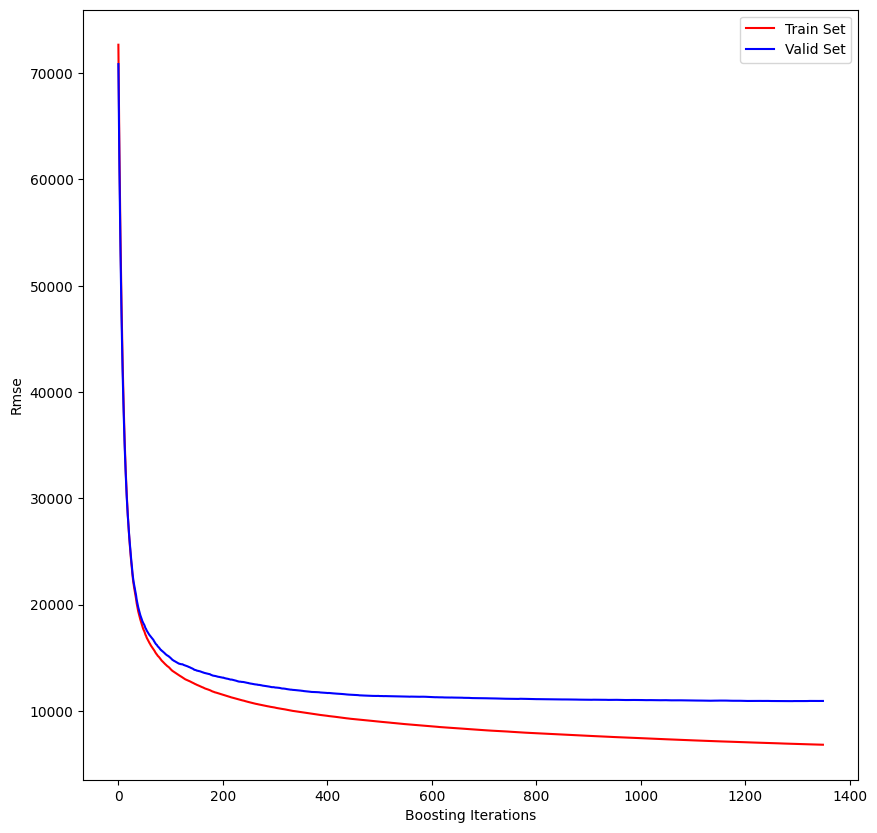

In [34]:
# 학습, 검증 rmse 시각화

model = model_list[0]

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.plot(np.arange(len(list(model.evals_result_['training']['rmse']))), list(model.evals_result_['training']['rmse']), linestyle='-', color='r', label='Train Set')
plt.plot(np.arange(len(list(model.evals_result_['training']['rmse']))), list(model.evals_result_['valid_1']['rmse']), linestyle='-', color='b', label='Valid Set')
plt.legend()
plt.xlabel('Boosting Iterations')
plt.ylabel('Rmse')
plt.show()

# 예측

In [36]:
preds_list = []

for i in range(len(test_df_list)):
    current = test_df_list[i]
    current = current.drop(['is_test', 'target', '지가지수', '아파트 인허가', '미분양', 
                            '건설사 랭킹', '구', '건물나이', '구매력지수', 
                            '거래활발지수', '매매가격 지수 증감률', '매매 대비 전세가격 비율'], axis=1)

    preds_list.append(model_list[i].predict(current))

In [38]:
preds_list[0]

array([184527.06137522, 322275.51644337, 313657.08892153, 284833.75342359,
       230781.10324483, 236112.37293293, 240710.60281826, 228577.04895541,
       188362.85722039, 417200.58820694, 266273.82486452, 258834.11653435,
       260916.73279917, 195216.73764027, 267899.31993123, 257131.40864165,
       197600.09375453, 273299.35241349, 255318.40951816, 271280.99167619,
       341488.60407199, 331263.25983636, 173960.27049874, 341050.85119538,
        39224.54222803,  38901.70307827, 165864.84343545, 223098.20989673,
       146754.4026627 , 158501.04017343, 235912.69081288, 228446.11584369,
       275992.8838596 , 237169.64464888, 279942.69646849, 282515.93516959,
        91267.33315227, 398696.38878556, 260561.56528822, 403289.71414787,
       271958.78110666, 187567.45638629, 181356.67146049, 259603.75881584,
       193595.76790897, 192342.8292009 , 335744.18842815, 328741.12380541,
       193003.39331739, 207275.60756885, 352916.26935527, 196238.93301316,
       204614.93493022, 2

### 결과 후처리

In [39]:
for i in range(25):
    preds_list[i] = np.round(preds_list[i]).astype(int)

In [40]:
preds_list[0]

array([184527, 322276, 313657, 284834, 230781, 236112, 240711, 228577,
       188363, 417201, 266274, 258834, 260917, 195217, 267899, 257131,
       197600, 273299, 255318, 271281, 341489, 331263, 173960, 341051,
        39225,  38902, 165865, 223098, 146754, 158501, 235913, 228446,
       275993, 237170, 279943, 282516,  91267, 398696, 260562, 403290,
       271959, 187567, 181357, 259604, 193596, 192343, 335744, 328741,
       193003, 207276, 352916, 196239, 204615, 279650, 196327, 281546,
       258604, 206174, 193654, 176692, 176692, 214723, 212231, 220822,
       176399, 175776, 376306, 233804, 261851, 178077, 235483, 256603,
       241165, 183283, 243200, 239467, 239632, 223944, 181371, 271561,
       270313, 203523, 269082, 209868, 236824, 212261, 238184, 216058,
       225518, 240471, 204969, 213556, 240071, 212431, 217287, 209401,
       230229, 230229, 215845, 218205, 242321, 209401, 206677, 242214,
       230229, 244023, 228002, 238836, 211262, 214336, 217371, 218366,
      

In [41]:
for i in range(25):
    test_df_list[i]['target'] = preds_list[i]
    print(test_df_list[i]['target'])

1118822    184527
1118823    322276
1118824    313657
1118825    284834
1118826    230781
            ...  
1123928    238324
1123929    237586
1123930    232988
1123931    174233
1123932    196861
Name: target, Length: 573, dtype: int64
1119165     66193
1119166     65071
1119167     65629
1119168     80225
1119169     80930
            ...  
1119995    114919
1119996    112837
1123933     88853
1123934     90464
1123935    105094
Name: target, Length: 530, dtype: int64
1119722    88810
1119723    69219
1119724    68938
1119725    68991
1119726    49635
           ...  
1120210    67165
1120211    52611
1120212    48975
1123936    44364
1123937    44364
Name: target, Length: 241, dtype: int64
1119745     61551
1119746     61837
1119747     47951
1119748     53491
1119749     44389
            ...  
1123939     78641
1123940     85263
1123941     64947
1123942    128692
1123946    100048
Name: target, Length: 431, dtype: int64
1120398     72210
1120399     74679
1120400    108546
11204

/tmp/ipykernel_588247/3017100242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_list[i]['target'] = preds_list[i]
/tmp/ipykernel_588247/3017100242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_list[i]['target'] = preds_list[i]
/tmp/ipykernel_588247/3017100242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [44]:
test_df_list[0][['target']]

,target
1118822,184527
1118823,322276
1118824,313657
1118825,284834
1118826,230781
...,...
1123928,238324
1123929,237586
1123930,232988
1123931,174233


In [45]:
# 결과 병합

re = pd.concat([preds for preds in test_df_list]).sort_index()

In [46]:
re[['target']].reset_index(drop=True)

,target
0,184527
1,322276
2,313657
3,284834
4,230781
...,...
9267,72556
9268,72428
9269,77310
9270,70098


In [47]:
re[['target']].reset_index(drop=True).to_csv('../preds/v_22_8_preds.csv', index=False)

In [48]:
for i in range(len(model_list)):
    joblib.dump(model_list[i], f'./v_22_8_district_models/v_22_8_{i}.pkl')